# Price Prediction of Used Cars

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from math import isnan
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Data Exploration

In [2]:
df = pd.read_csv('USA_cars_datasets.csv', index_col=0)

In [3]:
print(f'shape: {df.shape}')
df.head()

shape: (2499, 12)


,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [4]:
df.isnull().sum()

price           0
brand           0
model           0
year            0
title_status    0
mileage         0
color           0
vin             0
lot             0
state           0
country         0
condition       0
dtype: int64

In [5]:
df.describe()

,price,year,mileage,lot
count,2499.000000,2499.000000,2.499000e+03,2.499000e+03
mean,18767.671469,2016.714286,5.229869e+04,1.676914e+08
std,12116.094936,3.442656,5.970552e+04,2.038772e+05
min,0.000000,1973.000000,0.000000e+00,1.593488e+08
25%,10200.000000,2016.000000,2.146650e+04,1.676253e+08
50%,16900.000000,2018.000000,3.536500e+04,1.677451e+08
75%,25555.500000,2019.000000,6.347250e+04,1.677798e+08
max,84900.000000,2020.000000,1.017936e+06,1.678055e+08


* The numeric variables are price, mileage and year. Lot doesn't tell as a lot and is not really numeric, as it's a rather random number set by the car producing company.
* There are some entries with price 0. We'll investigate that and the lower end and get rid of them if they are not useful

In [6]:
print(f'{df[df.price==0].shape} observations with price 0',
      f'{len(df[df.price==0].brand.unique())} brands: {df[df.price==0].brand.unique()}',
     sep='\n')

(43, 12) observations with price 0
14 brands: ['dodge' 'ford' 'mazda' 'chevrolet' 'honda' 'gmc' 'heartland' 'cadillac'
 'buick' 'kia' 'audi' 'bmw' 'lincoln' 'peterbilt']


In [7]:
df[(df.price == 0)]

,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
141,0,dodge,van,2008,salvage insurance,177948.0,orange,2d8hn44h88r669549,167756157,utah,usa,2 days left
144,0,dodge,door,2014,salvage insurance,123660.0,silver,1c3cdzab0en111068,167756167,utah,usa,2 days left
196,0,ford,mpv,2017,clean vehicle,76858.0,white,1fbax2cv0hkb32599,167656523,texas,usa,2 days left
285,0,ford,door,2000,salvage insurance,124969.0,black,1fafp34p7yw270338,167251902,oklahoma,usa,17 hours left
290,0,mazda,door,2009,salvage insurance,117541.0,gray,jm3er293590215768,167543177,indiana,usa,16 hours left
293,0,chevrolet,pickup,1998,salvage insurance,258631.0,gray,1gccs1445wk226994,167417659,texas,usa,17 hours left
297,0,honda,door,2003,salvage insurance,152608.0,white,1hgcm56363a030975,167552893,arkansas,usa,17 hours left
305,0,ford,door,2003,salvage insurance,246065.0,gold,1fafp55u03a242094,167610324,kansas,usa,8 days left
309,0,chevrolet,door,2004,salvage insurance,0.0,maroon,3gnek12t74g240524,167418651,wyoming,usa,18 hours left
310,0,chevrolet,door,2003,salvage insurance,194673.0,gray,1gndt13s632267445,167650636,texas,usa,18 hours left


* They are all salvage insurance, and there are many transaction for very small amoounts (below 1000). Maybe they actually got sold for 0, so we'll keep them
* Also not quite clear where to do the cutoff because of the sales with small amounts (values like 25, 75, ...)

In [8]:
pd.DataFrame([df[df.price==0].brand.value_counts(), df[df.brand.apply(lambda x: x in df[df.price==0].brand.unique())].groupby('brand', axis=0).apply(lambda x: len(x))])

,ford,chevrolet,dodge,gmc,mazda,honda,heartland,cadillac,buick,kia,audi,bmw,lincoln,peterbilt
brand,18,11,2,2,1,1,1,1,1,1,1,1,1,1
Unnamed 0,1235,297,432,42,2,12,5,10,13,13,4,17,2,4


In [9]:
for col in [categorical for categorical in df.columns if categorical not in df.describe().columns]:
    print(f'column {col}, {len(df[col].unique())} unique values')

column brand, 28 unique values
column model, 127 unique values
column title_status, 2 unique values
column color, 49 unique values
column vin, 2495 unique values
column state, 44 unique values
column country, 2 unique values
column condition, 47 unique values


We can get rid of the variable vin, as it is almost unique for each entry, and judging from the table above it is something similar to a serial number.

In [10]:
len(df.lot.unique())

2495

* As thought, lot is not a useful variable, so we'll get rid of it as well.

* Regarding the categorical variables, most have a lot of categories, and only title_status and condition seem easily ordinable. The rest should be one-hot encoded in order for the to be fed into the regression, although that will heavily increase the number of variables.

* Wit a regression with variable selection (LASSO) we might find out that some of these categories are only important when they take certain variables (i.e., only certain brands of cars)

In [11]:
df.drop(['vin', 'lot'], axis=1, inplace=True)

#### Categorical Variables

In [12]:
df.title_status.unique()

array(['clean vehicle', 'salvage insurance'], dtype=object)

In [13]:
df.condition.unique()

array(['10 days left', '6 days left', '2 days left', '22 hours left',
       '20 hours left', '19 hours left', '3 days left', '21 hours left',
       '17 hours left', '2 hours left', '3 hours left', '34 minutes',
       '16 hours left', '18 hours left', '1 days left', '32 minutes',
       '14 hours left', '5 hours left', '4 days left', '9 days left',
       '23 hours left', '8 days left', '7 days left', '5 days left',
       '9 minutes', '1 minutes', '7 hours left', '16 minutes',
       '6 hours left', '1 hours left', 'Listing Expired', '13 days left',
       '24 hours left', '15 hours left', '53 minutes', '27 minutes',
       '12 days left', '15 days left', '30 minutes', '29 minutes',
       '28 minutes', '48 minutes', '11 days left', '4 hours left',
       '47 minutes', '12 hours left', '36 minutes'], dtype=object)

* title_status is not quite ordinable
* condition can be turned into a numeric variable, we'll choose the unit as minutes

In [14]:
brand_freq = df.brand.value_counts().apply(lambda x: x / df.shape[0])
brand_freq

ford               0.494198
dodge              0.172869
nissan             0.124850
chevrolet          0.118848
gmc                0.016807
jeep               0.012005
chrysler           0.007203
bmw                0.006803
hyundai            0.006002
kia                0.005202
buick              0.005202
infiniti           0.004802
honda              0.004802
cadillac           0.004002
mercedes-benz      0.004002
heartland          0.002001
land               0.001601
peterbilt          0.001601
audi               0.001601
acura              0.001200
lincoln            0.000800
lexus              0.000800
mazda              0.000800
maserati           0.000400
toyota             0.000400
harley-davidson    0.000400
jaguar             0.000400
ram                0.000400
Name: brand, dtype: float64

## Reformat Variables

#### Condition

We'll begin by converting the condition variable into a numerical one, measured in minutes, as mentioned above.

In [15]:
def convert_condition(string):
    convert = ''
    min_count = 0

    for i, e in enumerate(string):
        try:
            int(e)

        except ValueError:
            if (i == len(string)-1):
                break
            if convert != '':                
                if string[i+1] == 'd':
                    min_count += (int(convert) * 24 * 60)
                elif string[i+1] == 'h':
                    min_count += (int(convert) * 60)
                elif string[i+1] == 'm':
                    min_count += (int(convert))
            convert = ''

        else:
            convert = convert + e
            
    return min_count

In [16]:
df['condition'] = df['condition'].apply(convert_condition)

#### Title Status

In [17]:
df.title_status.unique()

array(['clean vehicle', 'salvage insurance'], dtype=object)

In [18]:
df.loc[df.loc[:, 'title_status'] == 'clean vehicle', 'title_status'] = 1
df.loc[df.loc[:, 'title_status'] == 'salvage insurance', 'title_status'] = 0
df.title_status = pd.to_numeric(df.title_status)

#### Country

In [19]:
df.country.unique()

array([' usa', ' canada'], dtype=object)

Since there's only 2 countries and (almost) all US states we can make one single variable out of both we call region, with US states and Canada in it.

In [20]:
country_freq = df.country.value_counts().apply(lambda x: x / df.shape[0])
country_freq

 usa       0.997199
 canada    0.002801
Name: country, dtype: float64

In [21]:
state_freq = df.state.value_counts().apply(lambda x: x / df.shape[0])
sum(state_freq > country_freq[1])

33

In [22]:
df[df.country==' canada']

,price,brand,model,year,title_status,mileage,color,state,country,condition
261,33000,chevrolet,1500,2018,1,52521.0,white,ontario,canada,14400
813,30000,dodge,charger,2019,1,43294.0,white,ontario,canada,14400
814,30000,dodge,charger,2019,1,54309.0,orange,ontario,canada,14400
815,30000,dodge,charger,2019,1,52822.0,white,ontario,canada,14400
816,30000,dodge,charger,2019,1,45554.0,white,ontario,canada,14400
817,30000,dodge,charger,2019,1,37538.0,white,ontario,canada,14400
818,29500,dodge,charger,2019,1,35153.0,red,ontario,canada,14400


Canada would be on the position 33 end of regions. Because all Canadian transactions happened in the sate of Ontario we can just get rid of the country column and leave Ontario

In [23]:
df.drop(columns='country', inplace=True)

* We are left over with categorical variables brand, model, color and state.
* There are 3 options:
    - One-hot Encoding
    - Number Encoding. This one imposes an arbitrary order in them, but they say it still performs well with random forests so it might be worth a try
    - Factor encoding in R, and run a forest there


### Brand and Model

In [24]:
df['brand_model'] = df.brand + '_' + df.model

In [25]:
len(df.model.unique())

127

In [26]:
len(df.brand_model.unique())

180

* We have more caregories when joining brand and model than with model separately
* It should be the same amount unless there are models from different brands with the same name

In [27]:
repeated = set()
non_repeated = set()
for l in df.sort_values('brand', axis=0).groupby('brand', axis=0)['model'].unique():
    for i in l:
        if i not in non_repeated:
            non_repeated.add(i)
        else:
            repeated.add(i)
print(f'These {len(repeated)}:\n', repeated)

These 13:
 {'van', 'doors', 'coupe', 'cab', 'pk', 'cutaway', 'mpv', '1500', 'cargo', 'pickup', 'sport', 'door', 'wagon'}


In [28]:
df.drop(columns=['brand', 'model'], inplace=True)

In [29]:
df.columns

Index(['price', 'year', 'title_status', 'mileage', 'color', 'state',
       'condition', 'brand_model'],
      dtype='object')

## Reduction of Categorical Variables

### Decision Trees
* Regression Tree
* Random Forest
* Bagging
* Boosting

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import tree

In [31]:
for i in ['color', 'state', 'brand_model']:
    print(i, len(df[i].unique()))  

color 49
state 44
brand_model 180


We'll try the 4 kinds of imported trees with label encoding and one-hot encoding

### Variable Encoding

In [32]:
df_le = df.copy()
df_oh = df.copy()

#### Label Encoding

In [33]:
le = preprocessing.LabelEncoder()

df_le.brand_model = le.fit_transform(df_le.brand_model)
df_le.state = le.fit_transform(df_le.state)
df_le.color = le.fit_transform(df_le.color)

#### One-hot Encoding

In [34]:
ohe = preprocessing.OneHotEncoder()

ohe.fit(df_oh.brand_model.unique().reshape(-1, 1))
df_oh = df_oh.join(pd.DataFrame.sparse.from_spmatrix(ohe.transform(np.asarray(df_oh.brand_model).reshape(-1, 1)), columns=ohe.categories_), on=None, how='outer')
df_oh.drop(columns=['brand_model'], inplace=True)

ohe.fit(df_oh.state.unique().reshape(-1, 1))
df_oh = df_oh.join(pd.DataFrame.sparse.from_spmatrix(ohe.transform(np.asarray(df_oh.state).reshape(-1, 1)), columns=ohe.categories_), on=None, how='outer')
df_oh.drop(columns=['state'], inplace=True)

ohe.fit(df_oh.color.unique().reshape(-1, 1))
df_oh = df_oh.join(pd.DataFrame.sparse.from_spmatrix(ohe.transform(np.asarray(df_oh.color).reshape(-1, 1)), columns=ohe.categories_), on=None, how='outer')
df_oh.drop(columns=['color'], inplace=True)

### Trees with Label Encoding

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_le.loc[:, df_le.columns != 'price'], df_le.price, test_size=0.25)

In [37]:
shuffle_5 = KFold(n_splits=5, shuffle=True)
strat_shuffle_5 = StratifiedKFold(n_splits=5, shuffle=True)

#### Regression Tree

In [38]:
regression_tree = DecisionTreeRegressor(random_state=0, min_samples_leaf=20)
reg_tree_scores = cross_val_score(regression_tree, df_le.loc[:, df_le.columns != 'price'], df_le.price, cv=shuffle_5)
print(f"scores: {reg_tree_scores}",
      f"average {np.mean(reg_tree_scores)}",
      f"std: {np.std(reg_tree_scores)}",
      sep='\n') 

scores: [0.51442118 0.48375041 0.45918667 0.54359176 0.46121746]
average 0.4924334977093701
std: 0.03242164089755465


In [39]:
regression_tree = DecisionTreeRegressor(random_state=0, min_samples_leaf=20)
regression_tree.fit(X_train, y_train)
regression_tree.score(X_test, y_test)

0.42528488225817696

In [40]:
reg_pred = regression_tree.apply(X_test)
print(f'MSE: {sum((reg_pred - y_test)**2) / len(y_test)}',
     f'Squared MSE: {np.sqrt(sum((reg_pred - y_test)**2) / len(y_test))}',
     f'MAE: {sum(abs(reg_pred - y_test)) / len(y_test)}',
     f'performs {regression_tree.get_depth()} splits',
      f'Ends with {regression_tree.get_n_leaves()} leaves', sep='\n')

MSE: 478541203.1664
Squared MSE: 21875.584635990876
MAE: 18254.6576
performs 11 splits
Ends with 70 leaves


In [41]:
regression_tree.tree_.node_count

139

In [42]:
regression_tree.get_n_leaves()

70

In [43]:
help(tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

## Trees with One-Hot Encoding

In [44]:
X_otrain, X_otest, y_otrain, y_otest = train_test_split(df_oh.loc[:, df_oh.columns != 'price'], df_oh.price, test_size=0.25)

#### Regression Tree

In [45]:
regression_tree_oh = DecisionTreeRegressor(random_state=0)
reg_tree_oh_scores = cross_val_score(regression_tree_oh, df_oh.loc[:, df_oh.columns != 'price'], df_oh.price, cv=shuffle_5)

print(f"scores: {reg_tree_oh_scores}",
      f"average {np.mean(reg_tree_oh_scores)}",
      f"std: {np.std(reg_tree_oh_scores)}",
      sep='\n') 


/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns fo

scores: [0.46358452 0.44392179 0.44573342 0.51772633 0.47231153]
average 0.4686555205422726
std: 0.026773890342525385


/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns fo

In [46]:
regression_tree_oh = DecisionTreeRegressor(random_state=0)
regression_tree_oh.fit(X_otrain, y_otrain)
regression_tree_oh.score(X_otest, y_otest)

/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns fo

0.4912160072372155

## Discretizing output variable price and ordering categories by prize

In [47]:
df.brand_model.unique().shape

(180,)

Since we have 180 different categories, we'll reduce them to one variable with 10 categories, each corresponding to on decile of the price distribution

In [48]:
df['price_range'] = pd.qcut(df.price, 10, labels=False)

In [49]:
df.groupby('price_range').apply(lambda x: len(x)).to_frame(name='number of obs').T

price_range,0,1,2,3,4,5,6,7,8,9
number of obs,252,250,248,257,249,243,251,249,250,250


In [50]:
brand_groups = df.groupby('price_range').brand_model.apply(lambda x: [len(x.unique()), x.unique()])
brand_groups

price_range
0    [54, [ford_se, ford_door, dodge_van, dodge_doo...
1    [56, [toyota_cruiser, dodge_mpv, chevrolet_pk,...
2    [59, [dodge_coupe, ford_door, ford_mpv, ford_f...
3    [49, [gmc_door, chevrolet_malibu, gmc_mpv, bui...
4    [42, [buick_encore, chevrolet_door, mercedes-b...
5    [59, [infiniti_q70, chevrolet_1500, chevrolet_...
6    [46, [ford_door, kia_sorento, chrysler_pacific...
7    [38, [ford_door, buick_enclave, buick_door, bm...
8    [39, [chevrolet_1500, chevrolet_camaro, chrysl...
9    [38, [ford_door, ford_srw, dodge_challenger, b...
Name: brand_model, dtype: object

In [51]:
for i, e in enumerate(brand_groups):
    n = i
    while n < (len(brand_groups)-1):
        n += 1
        intersect = list(set(e[1]).intersection(set(brand_groups[n][1])))
        print(f'intersection of group {i} with group {n}. {len(intersect)} intersections: {intersect}')

intersection of group 0 with group 1. 30 intersections: ['bmw_door', 'honda_doors', 'ford_pk', 'nissan_door', 'ford_doors', 'hyundai_doors', 'gmc_mpv', 'nissan_sentra', 'chevrolet_door', 'dodge_mpv', 'chrysler_door', 'dodge_door', 'hyundai_door', 'chevrolet_coupe', 'jeep_door', 'ford_mpv', 'dodge_van', 'chevrolet_pickup', 'ford_wagon', 'heartland_country', 'ford_van', 'ford_pickup', 'nissan_doors', 'honda_door', 'ford_fiesta', 'gmc_door', 'ford_chassis', 'nissan_mpv', 'ford_door', 'chevrolet_van']
intersection of group 0 with group 2. 21 intersections: ['nissan_door', 'ford_doors', 'gmc_mpv', 'nissan_sentra', 'chevrolet_door', 'dodge_mpv', 'dodge_door', 'hyundai_door', 'nissan_altima', 'ford_mpv', 'chevrolet_cruze', 'dodge_van', 'ford_van', 'nissan_doors', 'ford_fiesta', 'nissan_frontier', 'nissan_note', 'gmc_door', 'ford_door', 'chevrolet_van', 'chevrolet_sonic']
intersection of group 0 with group 3. 15 intersections: ['kia_door', 'ford_van', 'nissan_door', 'gmc_door', 'dodge_door', '

there are intersections among groups, but the further away from each other the less. By using the random forest we hope to get subgroups of brand_models that are better separated

In [52]:
pd.set_option('display.max_colwidth', 60)
df.groupby('price_range').price.apply(lambda x: [np.min(x), np.percentile(x, 25), np.median(x),
                                                 np.percentile(x, 75), np.max(x),
                                                 round(np.mean(x), 1), round(np.std(x), 1)]).to_frame(name='Summary Statistics per Decile')

,Summary Statistics per Decile
price_range,
0,"[0, 68.75, 2000.0, 3307.5, 4140, 1925.1, 1510.1]"
1,"[4150, 5100.0, 6220.0, 7300.0, 8000, 6192.7, 1199.9]"
2,"[8020, 9170.0, 10247.5, 10917.5, 11600, 10013.5, 1014.8]"
3,"[11621, 12780.0, 13500.0, 13995.0, 14700, 13378.4, 821.8]"
4,"[14750, 15322.0, 15800.0, 16500.0, 16900, 15843.9, 613.7]"
5,"[16995, 17700.0, 18500.0, 19300.0, 20159, 18501.5, 931.7]"
6,"[20200, 21500.0, 22500.0, 23100.0, 23800, 22261.9, 1034.5]"
7,"[23900, 24800.0, 25600.0, 26500.0, 27500, 25641.4, 1043.5]"
8,"[27502, 28800.0, 30000.0, 31767.5, 33700, 30268.8, 1740.8]"


Same procedure again of label encoding and one-hot encoding

### Categorization Label Encoding

In [53]:
df_cat_le = df.copy()
df_cat_le.drop(columns='price', inplace=True)

In [54]:
le = preprocessing.LabelEncoder()

df_cat_le.brand_model = le.fit_transform(df_cat_le.brand_model)
df_cat_le.state = le.fit_transform(df_cat_le.state)
df_cat_le.color = le.fit_transform(df_cat_le.color)

### Categorization One-hot Encoding

In [55]:
df_cat_oh = df.copy()
df_cat_oh.drop(columns='price', inplace=True)

In [56]:
ohe = preprocessing.OneHotEncoder()

ohe.fit(df_cat_oh.brand_model.unique().reshape(-1, 1))
df_cat_oh = df_cat_oh.join(pd.DataFrame.sparse.from_spmatrix(ohe.transform(np.asarray(df_cat_oh.brand_model).reshape(-1, 1)), columns=ohe.categories_), on=None, how='outer')
df_cat_oh.drop(columns=['brand_model'], inplace=True)

ohe.fit(df_cat_oh.state.unique().reshape(-1, 1))
df_cat_oh = df_cat_oh.join(pd.DataFrame.sparse.from_spmatrix(ohe.transform(np.asarray(df_cat_oh.state).reshape(-1, 1)), columns=ohe.categories_), on=None, how='outer')
df_cat_oh.drop(columns=['state'], inplace=True)

ohe.fit(df_cat_oh.color.unique().reshape(-1, 1))
df_cat_oh = df_cat_oh.join(pd.DataFrame.sparse.from_spmatrix(ohe.transform(np.asarray(df_cat_oh.color).reshape(-1, 1)), columns=ohe.categories_), on=None, how='outer')
df_cat_oh.drop(columns=['color'], inplace=True)

## Tree Classifiers

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [58]:
Xclf_test, Xclf_train, yclf_test, yclf_train = train_test_split(df_cat_le.loc[:, df_cat_le.columns != 'price_range'], df_cat_le.price_range, test_size=0.25)

In [59]:
classification_tree = DecisionTreeClassifier(random_state=0)
clf_tree_scores = cross_val_score(classification_tree, df_cat_le.loc[:, df_cat_le.columns != 'price_range'], df_cat_le.price_range, cv=strat_shuffle_5)
print(f"scores: {clf_tree_scores}",
      f"average {np.mean(clf_tree_scores)}",
      f"std: {np.std(clf_tree_scores)}",
      sep='\n') 

scores: [0.442      0.4        0.46       0.432      0.41482966]
average 0.4297659318637274
std: 0.020870387140283324


In [60]:
classification_tree.fit(Xclf_train, yclf_train)

DecisionTreeClassifier(random_state=0)

In [61]:
classification_tree.score(Xclf_test, yclf_test)

0.35699039487726786

In [62]:
classification_tree.get_n_leaves()

319

In [63]:
clf_tree_scores = cross_val_score(classification_tree, df_cat_le.loc[:, df_cat_le.columns != 'price_range'], df_cat_le.price_range, cv=strat_shuffle_5)
print(f"scores: {clf_tree_scores}",
      f"average {np.mean(clf_tree_scores)}",
      f"std: {np.std(clf_tree_scores)}",
      sep='\n') 

scores: [0.444      0.436      0.41       0.41       0.43687375]
average 0.427374749498998
std: 0.014455370653565591


## Lasso with Leaves Results

In [64]:
df_le['leaf'] = regression_tree.apply(df_le.loc[:, df_le.columns != 'price'])

In [65]:
df_cat_le['leaf'] = classification_tree.predict(df_cat_le.loc[:, df_cat_le.columns != 'price_range'])

* The Regression tree outputted 73 different leaves, so we have one value for each leaf
* The Classification tree outputted several leaves as well, but we'll use it's variable prediction instead

### Lasso with regression results

In [66]:
from sklearn.linear_model import LassoCV

In [67]:
variables = [i for i in df_le.columns if i != 'price']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_le[variables], df_le.price, train_size=0.8)

In [69]:
lassocv_model = LassoCV(alphas=np.arange(0, 5, 0.2), max_iter=5000, tol=0.0001, cv=shuffle_5, random_state=0).fit(df_le[variables], df_le.price)
print(f'best penalization term: {lassocv_model.alpha_}',
      f'R^2: {lassocv_model.score(X_test, y_test)}',
      f'MSE: {sum((lassocv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(lassocv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96266114923.35037, tolerance: 29292038.166340753
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-pac

best penalization term: 0.0
R^2: 0.3833502602746651
MSE: 86620354.09343734
MAE: 6701.684343688782


/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+11, tolerance: 3.667e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [70]:
print(f'best penalization term: {lassocv_model.alpha_}',
      f'R^2: {lassocv_model.score(X_test, y_test)}',
      f'MSE: {sum((lassocv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(lassocv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')



best penalization term: 0.0
R^2: 0.3833502602746651
MSE: 86620354.09343734
MAE: 6701.684343688782


### Ridge with regression results

In [71]:
from sklearn.linear_model import RidgeCV

In [72]:
ridgecv_model = RidgeCV(alphas=np.arange(0, 2, 0.1), cv=shuffle_5).fit(df_le[variables], df_le.price)

In [73]:
print(f'best penalization term: {ridgecv_model.alpha_}',
      f'R^2: {ridgecv_model.score(X_test, y_test)}',
      f'MSE: {sum((ridgecv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(ridgecv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

best penalization term: 0.0
R^2: 0.3833502602746647
MSE: 86620354.09343743
MAE: 6701.684343688781


### Lasso with classification results

In [74]:
df_cat_le.drop(columns=['price_range'], inplace=True)
df_cat_le['price'] = df.price

In [75]:
variables = [i for i in df_cat_le.columns if i != 'price']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_cat_le[variables], df_cat_le.price, train_size=0.8)

In [77]:
lassocv_model = LassoCV(alphas=np.arange(0, 5, 0.2), max_iter=5000, tol=0.0001, cv=shuffle_5, random_state=0).fit(df_cat_le[variables], df_cat_le.price)

/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77381795771.09863, tolerance: 29639823.814210933
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-pac

In [78]:
print(f'best penalization term: {lassocv_model.alpha_}',
      f'R^2: {lassocv_model.score(X_test, y_test)}',
      f'MSE: {sum((lassocv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(lassocv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')



best penalization term: 0.0
R^2: 0.49085667918956577
MSE: 71043670.59033518
MAE: 5556.094430405095


### Ridge with classification results

In [79]:
ridgecv_model = RidgeCV(alphas=np.arange(0, 2, 0.1), cv=5).fit(df_cat_le[variables], df_cat_le.price)

In [80]:
print(f'best penalization term: {ridgecv_model.alpha_}',
      f'R^2: {ridgecv_model.score(X_test, y_test)}',
      f'MSE: {sum((ridgecv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(ridgecv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

best penalization term: 1.9000000000000001
R^2: 0.4908294402864616
MSE: 71047471.38979629
MAE: 5556.584623248102


In [81]:

X_train.columns

Index(['year', 'title_status', 'mileage', 'color', 'state', 'condition',
       'brand_model', 'leaf'],
      dtype='object')

## K-Means

In [82]:
from sklearn.cluster import KMeans

In [83]:
df_cluster = df_le.drop(columns=['leaf', 'brand_model'])
df_cluster['brand_model'] = df.brand_model

In [84]:
df_cluster.head()

,price,year,title_status,mileage,color,state,condition,brand_model
0,6300,2008,1,274117.0,2,24,14400,toyota_cruiser
1,2899,2011,1,190552.0,39,35,8640,ford_se
2,5350,2018,1,39590.0,39,7,2880,dodge_mpv
3,25000,2014,1,64146.0,4,39,1320,ford_door
4,27700,2018,1,6654.0,34,6,1320,chevrolet_1500


In [85]:
df_cluster.columns

Index(['price', 'year', 'title_status', 'mileage', 'color', 'state',
       'condition', 'brand_model'],
      dtype='object')

In [86]:
df_cluster[['price', 'year', 'title_status', 'mileage', 'color', 'state', 'condition']]

,price,year,title_status,mileage,color,state,condition
0,6300,2008,1,274117.0,2,24,14400
1,2899,2011,1,190552.0,39,35,8640
2,5350,2018,1,39590.0,39,7,2880
3,25000,2014,1,64146.0,4,39,1320
4,27700,2018,1,6654.0,34,6,1320
...,...,...,...,...,...,...,...
2494,7800,2019,1,23609.0,34,3,1440
2495,9200,2018,1,34553.0,39,6,1260
2496,9200,2018,1,31594.0,39,6,1260
2497,9200,2018,1,32557.0,2,6,2880


In [87]:
clusters = KMeans(n_clusters=15)
clusters.fit_predict(df_cluster[['price', 'year', 'title_status', 'mileage', 'color', 'state', 'condition']])

array([ 5,  3, 11, ..., 11, 11, 11], dtype=int32)

In [88]:
df_cluster['cluster'] = clusters.fit_predict(df_cluster[['price', 'year', 'title_status', 'mileage', 'color', 'state', 'condition']])

In [89]:
df_cluster

,price,year,title_status,mileage,color,state,condition,brand_model,cluster
0,6300,2008,1,274117.0,2,24,14400,toyota_cruiser,8
1,2899,2011,1,190552.0,39,35,8640,ford_se,10
2,5350,2018,1,39590.0,39,7,2880,dodge_mpv,0
3,25000,2014,1,64146.0,4,39,1320,ford_door,9
4,27700,2018,1,6654.0,34,6,1320,chevrolet_1500,5
...,...,...,...,...,...,...,...,...,...
2494,7800,2019,1,23609.0,34,3,1440,nissan_versa,12
2495,9200,2018,1,34553.0,39,6,1260,nissan_versa,0
2496,9200,2018,1,31594.0,39,6,1260,nissan_versa,0
2497,9200,2018,1,32557.0,2,6,2880,nissan_versa,0


In [90]:
df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')]

,year,title_status,mileage,color,state,condition,cluster
0,2008,1,274117.0,2,24,14400,8
1,2011,1,190552.0,39,35,8640,10
2,2018,1,39590.0,39,7,2880,0
3,2014,1,64146.0,4,39,1320,9
4,2018,1,6654.0,34,6,1320,5
...,...,...,...,...,...,...,...
2494,2019,1,23609.0,34,3,1440,12
2495,2018,1,34553.0,39,6,1260,0
2496,2018,1,31594.0,39,6,1260,0
2497,2018,1,32557.0,2,6,2880,0


In [91]:
df_cluster.groupby('cluster').price.apply(lambda x: [np.min(x), np.percentile(x, 25), np.median(x),
                                                 np.percentile(x, 75), np.max(x),
                                                 round(np.mean(x), 1), round(np.std(x), 1)]).to_frame(name='Summary Statistics per Decile')

,Summary Statistics per Decile
cluster,
0,"[25, 10830.0, 14650.0, 16600.0, 22700, 13522.7, 4725.7]"
1,"[0, 1400.0, 6000.0, 12895.0, 34000, 8090.3, 8027.7]"
2,"[0, 356.25, 750.0, 1568.75, 3200, 1175.0, 1224.1]"
3,"[0, 6500.0, 10940.0, 17400.0, 50200, 12784.7, 8788.7]"
4,"[0, 18.75, 875.0, 6760.0, 13000, 3334.8, 3849.7]"
5,"[19000, 23500.0, 27000.0, 30000.0, 39950, 27451.0, 4378.9]"
6,"[0, 4000.0, 7000.0, 12125.0, 33800, 8866.8, 6846.8]"
7,"[38600, 45900.0, 49000.0, 55000.0, 84900, 51074.1, 7801.5]"
8,"[0, 0.0, 50.0, 3556.25, 15700, 2771.1, 4326.9]"


{'whiskers': [<matplotlib.lines.Line2D at 0x1352e4580>,
 'caps': [<matplotlib.lines.Line2D at 0x1352e4be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1352e4130>,
 'medians': [<matplotlib.lines.Line2D at 0x1352f1340>,
 'fliers': [<matplotlib.lines.Line2D at 0x1352f16d0>,
 'means': []}

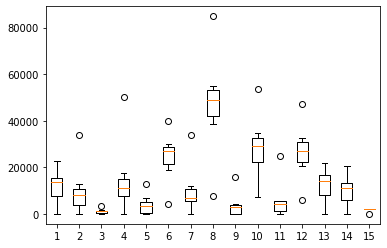

In [92]:
plt.boxplot(df_cluster.groupby('cluster').price.apply(lambda x: [np.min(x), np.percentile(x, 25), np.median(x),
                                                 np.percentile(x, 75), np.max(x),
                                                 round(np.mean(x), 1), round(np.std(x), 1)]).to_frame(name='Summary Statistics per Decile')['Summary Statistics per Decile'])

In [93]:
df_cluster.groupby('cluster').price.apply(lambda x: [min(x), n])

cluster
0        [25, 9]
1         [0, 9]
2         [0, 9]
3         [0, 9]
4         [0, 9]
5     [19000, 9]
6         [0, 9]
7     [38600, 9]
8         [0, 9]
9     [20000, 9]
10        [0, 9]
11    [20500, 9]
12        [0, 9]
13      [125, 9]
14     [2000, 9]
Name: price, dtype: object

<AxesSubplot:xlabel='cluster'>

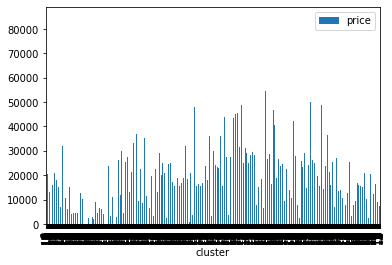

In [94]:
df_cluster.plot.bar(x='cluster', y='price')

In [95]:
df_cluster.price

0        6300
1        2899
2        5350
3       25000
4       27700
        ...  
2494     7800
2495     9200
2496     9200
2497     9200
2498     9200
Name: price, Length: 2499, dtype: int64

In [96]:
lassocv_model = LassoCV(alphas=np.arange(0, 5, 0.2), max_iter=5000, tol=0.0001, cv=shuffle_5, random_state=0).fit(df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')], df_cluster.price)

/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106393112451.26503, tolerance: 28369497.275229037
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-pa

In [97]:
X_train, X_test, y_train, y_test = train_test_split(df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')], df_cluster.price, train_size=0.8)

In [98]:
lassocv_model = LassoCV(alphas=np.arange(0, 5, 0.2), max_iter=5000, tol=0.0001, cv=shuffle_5, random_state=0).fit(df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')], df_cluster.price)
print(f'best penalization term: {lassocv_model.alpha_}',
      f'R^2: {lassocv_model.score(X_test, y_test)}',
      f'MSE: {sum((lassocv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(lassocv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108773580587.04213, tolerance: 29421280.990250837
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-pa

best penalization term: 0.0
R^2: 0.2296110542151164
MSE: 109453005.06298922
MAE: 8065.376010727436


/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+11, tolerance: 3.667e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


## Polynomial Regression and Splines

In [99]:
from sklearn.preprocessing import PolynomialFeatures

In [100]:
df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')].shape

(2499, 7)

In [101]:
df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')]

,year,title_status,mileage,color,state,condition,cluster
0,2008,1,274117.0,2,24,14400,8
1,2011,1,190552.0,39,35,8640,10
2,2018,1,39590.0,39,7,2880,0
3,2014,1,64146.0,4,39,1320,9
4,2018,1,6654.0,34,6,1320,5
...,...,...,...,...,...,...,...
2494,2019,1,23609.0,34,3,1440,12
2495,2018,1,34553.0,39,6,1260,0
2496,2018,1,31594.0,39,6,1260,0
2497,2018,1,32557.0,2,6,2880,0


In [102]:
poly = PolynomialFeatures(3)
poly.fit_transform(df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')]).shape



(2499, 120)

In [103]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

In [105]:
shuffle_5

KFold(n_splits=5, random_state=None, shuffle=True)

In [106]:
model = make_pipeline(SplineTransformer(n_knots=4, degree=3),
                      RidgeCV(alphas=np.arange(0, 2, 0.1), cv=shuffle_5))
model.fit(df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')], df_cluster.price)


Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=4)),
                ('ridgecv',
                 RidgeCV(alphas=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         cv=KFold(n_splits=5, random_state=None, shuffle=True)))])

In [110]:
model.score(X_train, y_train)

0.6537900776878136

### Lasso Splines

In [111]:
model = make_pipeline(SplineTransformer(n_knots=4, degree=3),
                      LassoCV(alphas=np.arange(0, 2, 0.1), cv=shuffle_5))
model.fit(df_cluster.loc[:, (df_cluster.columns != 'price') & (df_cluster.columns != 'brand_model')], df_cluster.price)



/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48327570823.76523, tolerance: 28890846.569023542
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javiermazonechevarria/.pyenv/versions/3.8.9/envs/test1/lib/python3.8/site-pac

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=4)),
                ('lassocv',
                 LassoCV(alphas=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         cv=KFold(n_splits=5, random_state=None, shuffle=True)))])

In [112]:
model.score(X_train, y_train)

0.6672303796601098

In [113]:
model.alpha_

AttributeError: 'Pipeline' object has no attribute 'alpha_'